In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
### READ DATA ###

data_path = "https://raw.githubusercontent.com/cerlymarco/MEDIUM_NoteBook/master/Hacking_Causal_Inference/smoking_data.csv"
df = pd.read_csv(data_path).drop(columns=["lnincome","beer", "age15to24"])
df['year'] = df['year'].astype(int)

df.head()

,state,year,cigsale,retprice
0,Alabama,1970,89.8,39.6
1,Alabama,1971,95.4,42.7
2,Alabama,1972,101.1,42.3
3,Alabama,1973,102.9,42.1
4,Alabama,1974,108.2,43.1


In [3]:
### UNPIVOT DATA (YEARS X STATES) ###

treatment_year = 1988
treated_state = 'California'

df = df.pivot(index= 'year', columns = 'state', values = "cigsale")

print(df.shape)
df.head()

(31, 39)


state,Alabama,Arkansas,California,Colorado,Connecticut,Delaware,Georgia,Idaho,Illinois,Indiana,...,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,West Virginia,Wisconsin,Wyoming
year,,,,,,,,,,,,,,,,,,,,,
1970,89.8,100.3,123.0,124.8,120.0,155.0,109.9,102.4,124.8,134.6,...,103.6,92.7,99.8,106.4,65.5,122.6,124.3,114.5,106.4,132.2
1971,95.4,104.1,121.0,125.5,117.6,161.1,115.7,108.5,125.6,139.3,...,115.0,96.7,106.3,108.9,67.7,124.4,128.4,111.5,105.4,131.7
1972,101.1,103.9,123.5,134.3,110.8,156.3,117.0,126.1,126.6,149.2,...,118.7,103.0,111.5,108.6,71.3,138.0,137.0,117.5,108.8,140.0
1973,102.9,108.0,124.4,137.9,109.3,154.7,119.8,121.8,124.4,156.0,...,125.5,103.5,109.7,110.4,72.7,146.8,143.1,116.6,109.5,141.2
1974,108.2,109.7,126.7,132.8,112.4,151.3,123.7,125.6,131.9,159.6,...,129.7,108.4,114.8,114.7,75.6,151.8,149.6,119.9,111.8,145.8


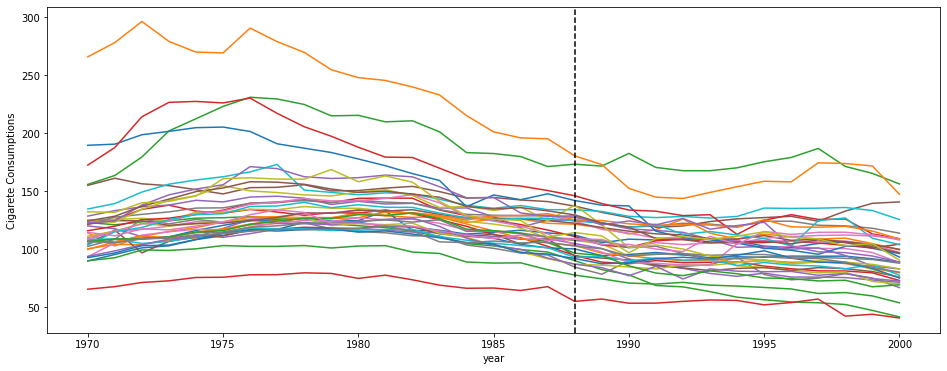

In [4]:
### PLOT DATA ###

df.plot(legend=False, figsize=(16,6))
plt.ylabel('Cigarete Consumptions')
plt.axvline(x=treatment_year, ls="--", label='treatment year', c='black')

In [5]:
### SPLIT DATA ACCORDING TREATMENT YEAR ###

df_train, df_test = train_test_split(
    df, 
    test_size=int(df.index.max() - treatment_year), shuffle=False
)

In [6]:
### FIT PCA BEFORE TREATMENT YEAR ###

pca = make_pipeline(StandardScaler(), PCA(n_components=1))
pca.fit(df_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=1))])

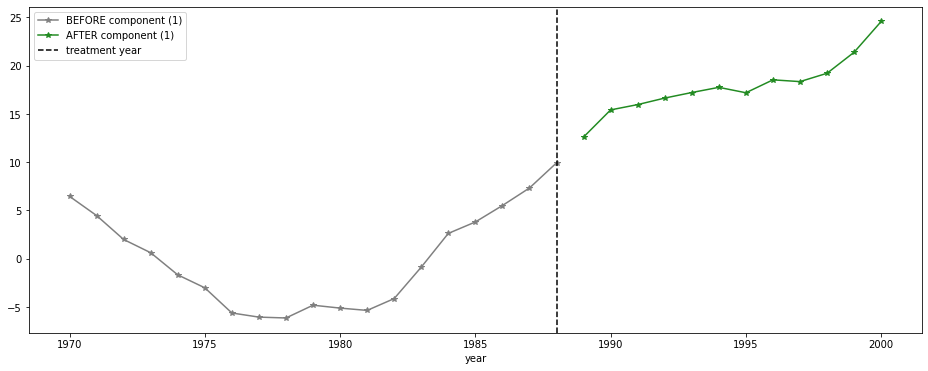

In [7]:
### PLOT PCA COMPONENTS OVER YEARS ###

pd.DataFrame({
    f'BEFORE component ({i+1})': c
    for i,c in enumerate(pca.transform(df_train).T)
}, index=df_train.index).plot(ax=plt.gca(), marker='*', c='grey', figsize=(16,6))
pd.DataFrame({
    f'AFTER component ({i+1})': c
    for i,c in enumerate(pca.transform(df_test).T)
}, index=df_test.index).plot(ax=plt.gca(), marker='*', c='forestgreen')
plt.axvline(x=treatment_year, ls="--", label='treatment year', c='black')
plt.legend()

In [8]:
### GET RECONSTRUCTION ERRORS OVER YEARS FOR EACH STATE ###

df_test_reconstruct = pca.steps[0][1].inverse_transform(
    pca.steps[-1][1].inverse_transform(pca.transform(df_test))
)
df_test_reconstruct = pd.DataFrame(
    df_test_reconstruct, 
    columns=df_test.columns, index=df_test.index
)
reconstruct_errors = (df_test - df_test_reconstruct).mean()

<AxesSubplot:xlabel='year'>

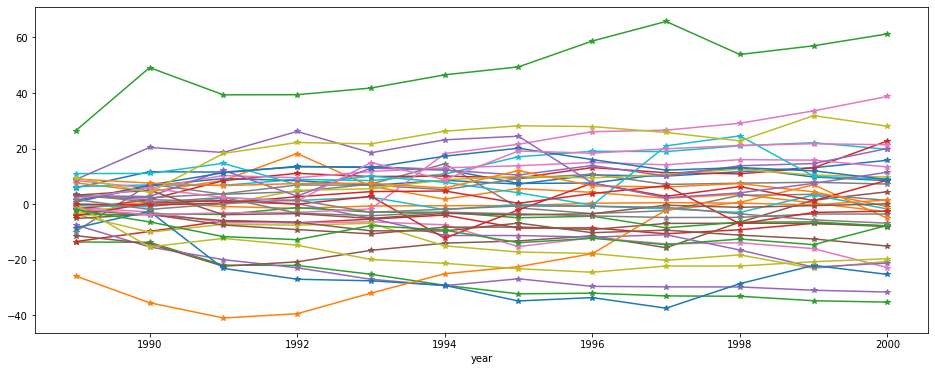

In [9]:
### PLOT RECONSTRUCTION ERRORS OVER YEARS FOR EACH STATE ###

(df_test - df_test_reconstruct).plot(legend=False, marker='*', figsize=(16,6))

<AxesSubplot:xlabel='state'>

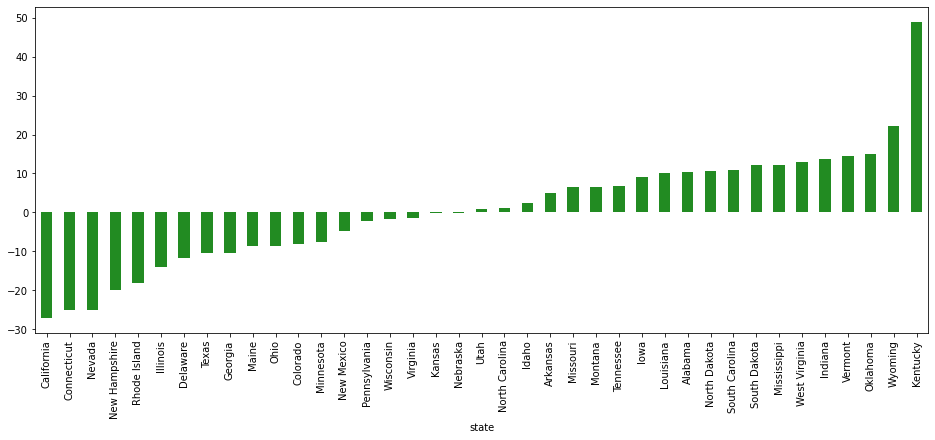

In [10]:
### PLOT RECONSTRUCTION ERRORS FOR EACH STATE ###

reconstruct_errors.sort_values().plot.bar(figsize=(16,6), color='forestgreen')